In [1]:
from scipy import *
from numpy import *
from matplotlib.pyplot import *
from matplotlib.animation import FuncAnimation
from scipy.linalg import *
from numpy.linalg import *
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.integrate import solve_ivp
from timeit import default_timer as timer
import FNC

In [2]:
# This (optional) block is for improving the display of plots.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg","pdf")
rcParams["figure.figsize"] = [7,4]
rcParams["lines.linewidth"] = 2
rcParams["lines.markersize"] = 4
rcParams['animation.html'] = "jshtml"  # or try "html5"

# Example 11.1.2

Here are the parameters for a particular simulation of the Black--Scholes equation.

In [3]:
Smax,T = 8, 6
K = 3
sigma = 0.06
r = 0.08

We discretize space and time.

In [4]:
m = 200
h = Smax / m
x = h*arange(m+1)
n = 1000
tau = T / n
t = tau*arange(n+1)
lamb,mu = tau / h**2, tau / h

Set the initial condition, then march forward in time. 

In [5]:
V = zeros([m+1,n+1])
V[:,0] = maximum( 0, x-K )
for j in range(n):
    # Fictitious value from Neumann condition.
    Vfict = 2*h + V[m-1,j]
    Vj = hstack( [V[:,j], Vfict] )
    # First row is zero by the Dirichlet condition.
    for i in range(1,m+1):
        diff1 = (Vj[i+1] - Vj[i-1])
        diff2 = (Vj[i+1] - 2*Vj[i] + Vj[i-1])
        V[i,j+1] = Vj[i] + (lamb*sigma**2*x[i]**2/2)*diff2 + (
        r*x[i]*mu)/2*diff1 - r*tau*Vj[i]

We plot at a few times.

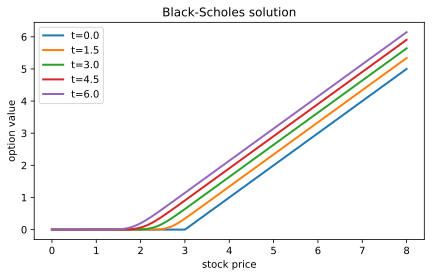

In [6]:
select_times = 250*arange(5)
show_times = t[select_times]

for j,col in enumerate(select_times):
    plot(x,V[:,col],label=f"t={show_times[j]:.1f}")
    
legend(); title("Black-Scholes solution");
xlabel("stock price"); ylabel("option value");

The lowest curve is the initial condition, and the highest curve is the last time. The results are easy to interpret, recalling that the time variable really means "time before strike." Say you are close to the option's strike time. If the current stock price is, say, $S=2$, then it's not likely that the stock will end up over the strike price $K=3$ and therefore the option has little value. On the other hand, if presently $S=3$, then there are good odds that the option will be exercised at the strike time, and you will need to pay a substantial portion of the stock price in order to take advantage.

Let's try to extend the simulation time to $T=8$, keeping everything else the same.

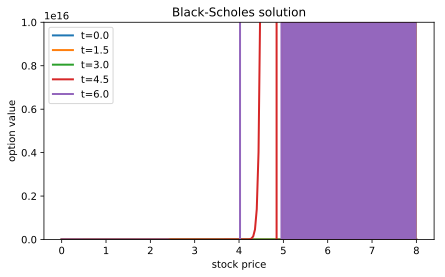

In [7]:
T,n = 8,1000
tau = T / n
t = tau*arange(n+1)
lamb,mu = tau / h**2, tau / h

for j in range(n):
    # Fictitious value from Neumann condition.
    Vfict = 2*h + V[m-1,j]
    Vj = hstack( [V[:,j], Vfict] )
    # First row is zero by the Dirichlet condition.
    for i in range(1,m+1):
        diff1 = (Vj[i+1] - Vj[i-1])
        diff2 = (Vj[i+1] - 2*Vj[i] + Vj[i-1])
        V[i,j+1] = Vj[i] + (lamb*sigma**2*x[i]**2/2)*diff2 + (
        r*x[i]*mu)/2*diff1 - r*tau*Vj[i]

for j,col in enumerate(select_times):
    plot(x,V[:,col],label=f"t={show_times[j]:.1f}")
    
legend(); title("Black-Scholes solution");
ylim([0,1e16])
xlabel("stock price"); ylabel("option value");

This "solution" is nonsensical.  Look at the scale of the ordinate!

# Example 11.2.1

Let's try out the Euler and backward Euler time stepping methods using the second-order semidiscretization:

In [8]:
m = 100
x,Dx,Dxx = FNC.diffper(m,[0,1]);

First we apply the Euler discretization. 

In [9]:
tfinal = 0.05;  n = 500;  
tau = tfinal/n;  t = tau*arange(n+1);
U = zeros([m,n+1]);
I = eye(m)

This is where we set the initial condition. It isn't mathematically periodic, but the end values and derivatives are so small that for numerical purposes it may as well be.

In [10]:
U[:,0] = exp( -60*(x-0.5)**2 )

The Euler time stepping simply multiplies by a constant matrix for each time step.

In [11]:
A = I + tau*Dxx;
for j in range(n):
    U[:,j+1] = A@U[:,j]

Things seem to start well.

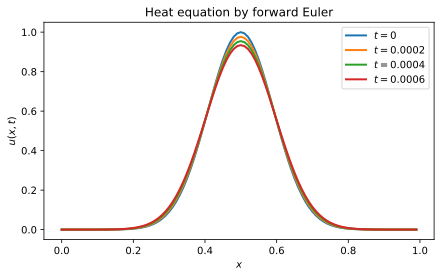

In [12]:
plot(x,U[:,:8:2])
xlabel("$x$"); ylabel("$u(x,t)$");
legend([f"$t={tj:.1g}$" for tj in t[:8:2]]); 
title("Heat equation by forward Euler");

Shortly thereafter, though, there is nonphysical growth. 

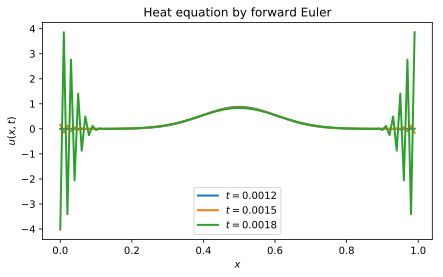

In [13]:
plot(x,U[:,12:21:3])
xlabel("$x$"); ylabel("$u(x,t)$");
legend([f"$t={tj:.2g}$" for tj in t[12:21:3]]); 
title("Heat equation by forward Euler");

The growth is exponential in time.

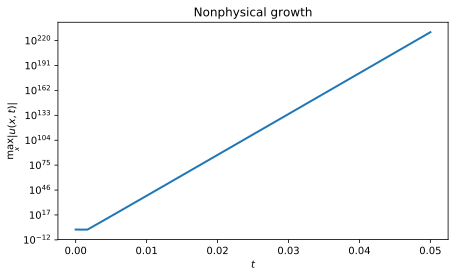

In [14]:
M = abs(U).max(axis=0)     # max in each column
semilogy(t,M)
xlabel("$t$"); ylabel("$\max_x |u(x,t)|$");
title("Nonphysical growth"); 

Now we try backward Euler. In this case there is a tridiagonal linear system to solve at each time step. We will use a sparse matrix to get sparse LU factorization, although the time savings at this size are negligible.

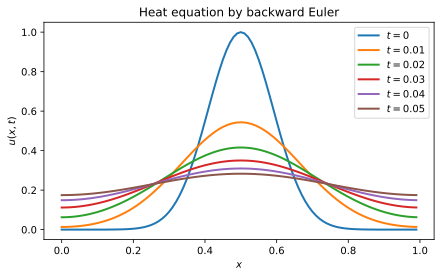

In [15]:
B = sp.csr_matrix(I - tau*Dxx)
for j in range(n):
    U[:,j+1] = spsolve(B,U[:,j])

plot(x,U[:,:600:100])
xlabel("$x$"); ylabel("$u(x,t)$");
legend([f"$t={tj:.2g}$" for tj in t[:600:100]]); 
title("Heat equation by backward Euler");

This solution looks physically realistic, as the large concentration in the center diffuses outward. Observe that the solution remains periodic in space. 

# Example 11.2.2

We set up the semidiscretization and initial condition in $x$ just as before.

In [16]:
m = 100
x,Dx,Dxx = FNC.diffper(m,[0,1])
u0 = exp( -60*(x-0.5)**2 )

Now, though, we apply a standard solver to the initial-value problem $\mathbf{u}'=\mathbf{D}_{xx}\mathbf{u}$.

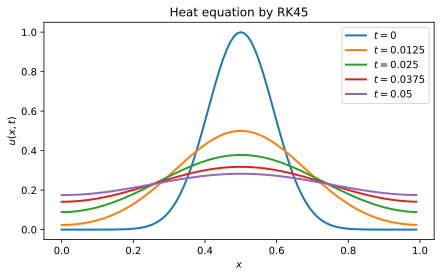

In [17]:
tfinal = 0.05
f = lambda t,u: Dxx@u
sol = solve_ivp(f,[0,tfinal],u0,method="RK45",dense_output=True)

t = linspace(0,0.05,5)
plot(x,sol.sol(t))  
xlabel("$x$"); ylabel("$u(x,t)$");
legend([f"$t={tj:.4g}$" for tj in t])
title("Heat equation by RK45");

The solution is at least plausible. But the number of time steps that were selected automatically is surprisingly large, considering how smoothly the solution changes.

In [18]:
print("number of RK45 steps:",len(sol.t)-1)

number of RK45 steps: 602


Now we apply another solver. 

In [19]:
sol = solve_ivp(f,[0,tfinal],u0,method="BDF",dense_output=True)

The number of steps selected is reduced by a factor of 20!

In [20]:
print("number of RK45 steps:",len(sol.t)-1)

number of RK45 steps: 34


# Example 11.3.3

Both time stepping methods solved $\mathbf{u}'=\mathbf{D}_{xx}\mathbf{u}$, for the matrix

In [21]:
m = 40
Dxx = FNC.diffper(m,[0,1])[2]

The eigenvalues of this matrix are real and negative.

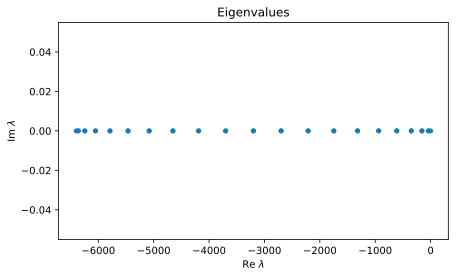

In [22]:
lamb = eigvals(Dxx)
plot(real(lamb),imag(lamb),"o")
xlabel("Re $\lambda$");  ylabel("Im $\lambda$");
title("Eigenvalues");

The Euler method is absolutely stable in the region $|\zeta+1| \le 1$ in the complex plane:

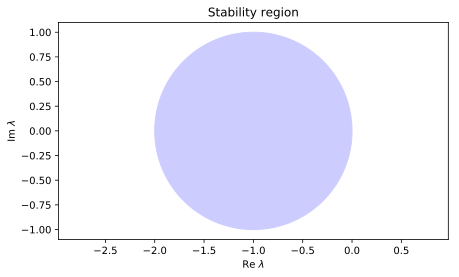

In [23]:
phi = 2*pi*arange(361)/360
z = exp(1j*phi) - 1     # unit circle shifted to the left by 1

fill(real(z),imag(z),color=(.8,.8,1))
xlabel("Re $\lambda$");  ylabel("Im $\lambda$");
axis("equal"); title("Stability region"); 

In order to get inside this region, we have to find $\tau$ such that $\lambda \tau > -2$ for all eigenvalues $\lambda$. This is an _upper_ bound on $\tau$. 

In [24]:
lambda_min = min(lamb)
max_tau = -2 / lambda_min
print(max_tau)

0.00031250000000000017


Here we plot the resulting values of $\zeta=\lambda \tau$. 

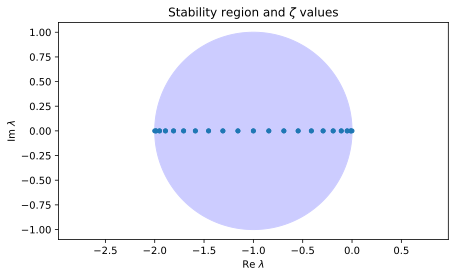

In [25]:
zeta = lamb*max_tau

fill(real(z),imag(z),color=(.8,.8,1))
plot(real(zeta),imag(zeta),"o")
xlabel("Re $\lambda$");  ylabel("Im $\lambda$");
axis("equal")
title("Stability region and $\zeta$ values");

In backward Euler, the region is $|\zeta-1|\ge 1$. Because they are all on the negative real axis, all of the $\zeta$ values will fit no matter what $\tau$ is chosen.

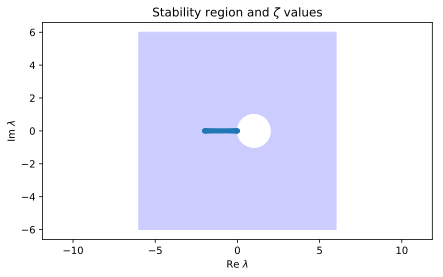

In [26]:
fill([-6,6,6,-6],[-6,-6,6,6],color=(.8,.8,1))
z = exp(1j*phi) + 1;   # unit circle shifted right by 1
fill(real(z),imag(z),color="w")

plot(real(zeta),imag(zeta),"o")
axis([-4,2,-3,3]); axis("equal");
xlabel("Re $\lambda$");  ylabel("Im $\lambda$");
title("Stability region and $\zeta$ values");

# Example 11.4.2

In [27]:
q,s,w = 8.375e-6,77.27,0.161
def ode(t,u):
    return array( 
    [ s*(u[1]-u[0]*u[1]+u[0]-q*u[0]**2),
    (-u[1]-u[0]*u[1]+u[2])/s, 
    w*(u[0]-u[2]) ] )

One of the stiff solvers, called `BDF`, is pretty fast here.

In [28]:
u0 = array([1.,1.,4.])
tspan = (0.,6.)
start = timer()
sol = solve_ivp(ode,tspan,u0,method="BDF")
print("solve time (stiff):",timer()-start)

solve time (stiff): 0.05031451999093406


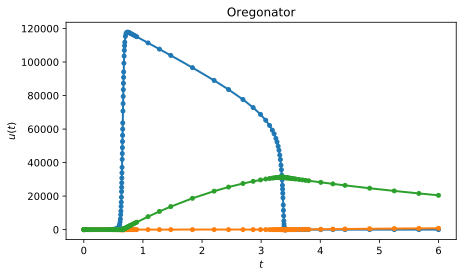

In [29]:
plot(sol.t,sol.y.T,"-o")
xlabel("$t$"); ylabel("$u(t)$");
title("Oregonator");

In [30]:
print("number of steps (stiff):",len(sol.t)-1)

number of steps (stiff): 164


You can see that the stiff solver takes small time steps only when some part of the solution is changing rapidly. However, a nonstiff solver, based on an explicit method, is much slower and takes a lot more steps.

In [31]:
start = timer()
sol = solve_ivp(ode,tspan,u0,method="RK45")
print("solve time (nonstiff):",timer()-start)

solve time (nonstiff): 2.6701283599832095


In [32]:
print("number of steps (nonstiff):",len(sol.t)-1)

number of steps (nonstiff): 28485


Here is the Jacobian matrix at any value of $\mathbf{u}$. 

In [33]:
J = lambda u: array( [ 
  [ -s*(u[1]+1-2*q*u[0]), s*(1-u[0]), 0], 
  [-u[1]/s, (-1-u[0])/s, 1/s], 
  [w, 0, -w] ])

During the early phase, the time steps seem fairly large. The eigenvalues around $t=1/2$ are 

In [34]:
t = sol.t
i1 = min(where(t>0.5))[0]
lambda1 = eigvals( J(sol.y[:,i1]) )
print("eigenvalues near time 0.5:",lambda1)

eigenvalues near time 0.5: [-131.83340303   -3.14384902   -0.34078324]


These are real and negative. Checking the stability region of RK4 along the negative real axis, we see that stability requires a maximum time step

In [35]:
print("estimated max step:", 2.8 / max(abs(lambda1)))

estimated max step: 0.021238926824379424


The actual step size chosen by the solver was comparable:

In [36]:
print("actual step:",t[i1+1]-t[i1])

actual step: 0.029545844269049604


Later in the simulation, the steps seem quite small compared to the apparent rate of activity. We look near $t=4$:

In [37]:
i2 = min(where(t>4))[0]
lambda2 = eigvals( J(sol.y[:,i2]) )
print("eigenvalues near time 4:",lambda2)

eigenvalues near time 4: [-1.82381944e+04 -2.58838704e-02 -1.60999672e-01]


These are also real and negative. We compare the maximum and observed step sizes again:

In [38]:
print("estimated max step:", 2.8 / max(abs(lambda2)))
print("actual step:",t[i2+1]-t[i2])

estimated max step: 0.00015352396963940487
actual step: 0.00020679478507457105


Again, the eigenvalues give a good indication of how the steps are being chosen, at least to order of magnitude.

# Example 11.5.3

We solve $u_t=u_{xx}$ on $[-1,1]$ subject to the Dirichlet conditions $u(-1,t)=0$, $u(1,t)=2$. 

In [39]:
m = 100
x,Dx,Dxx = FNC.diffcheb(m,[-1,1])

Our next step is to write a function that defines $\mathbf{f}$. Since the boundary values are given explicitly, there is no need to "solve" for them---we just append them to each end of the vector.

In [40]:
extend = lambda v: hstack([0,v,2])

We can also define the inverse operation of chopping off the boundary values from a full vector.

In [41]:
chop = lambda u: u[1:-1]

All the pieces are now in place to define and solve the IVP.

In [42]:
def f(t,v):
    u = extend(v)
    phi = Dxx@u
    return chop(phi)

u0 = 1 + sin(pi/2*x) + 3*(1-x**2)*exp(-4*x**2)
sol = solve_ivp(f,(0,0.15),chop(u0),method="BDF",dense_output=True)

We extend the solution to the boundaries at each time, then plot.

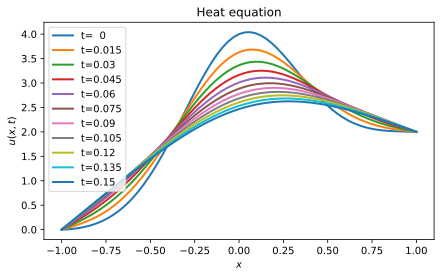

In [43]:
t = linspace(0,0.15,11) 
U = vstack( [extend(sol.sol(tj)) for tj in t] )
plot(x,U.T)
xlabel("$x$"); ylabel("$u(x,t)$");
legend([f"t={tj:3g}" for tj in t])
title("Heat equation");

# Example 11.5.4

We solve a diffusion equation with source term: $u_t=u^2+u_{xx}$, on $[-1,1]$ subject to homogeneous Dirichlet conditions. 

In [44]:
m = 100
x,Dx,Dxx = FNC.diffcheb(m,[-1,1])

In [45]:
extend = lambda v: hstack([0,v,0])  # extend to boundary
chop = lambda u: u[1:-1]            # discard boundary
def ODE(t,v):
    u = extend(v)
    uxx = Dxx@u
    return chop(u**2 + uxx)

All the pieces are now in place to define and solve the IVP.

In [46]:
u0 = 6*(1-x**2)*exp(-4*(x-.5)**2)
sol = solve_ivp(ODE,(0,1.5),chop(u0),method="BDF",dense_output=True)

Extend the solution to the boundaries at each time, then plot.

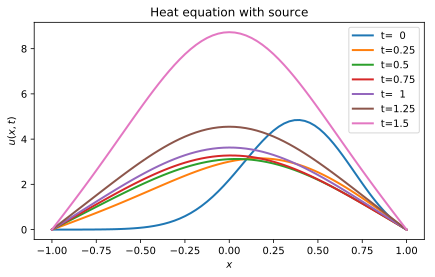

In [47]:
t = linspace(0,1.5,7)
U = vstack( [extend(sol.sol(tj)) for tj in t] )
plot(x,U.T)
xlabel("$x$"); ylabel("$u(x,t)$");
legend([f"t={tj:3g}" for tj in t])
title("Heat equation with source");

An animation better captures how the source term takes over gradually but at an accelerating rate. 

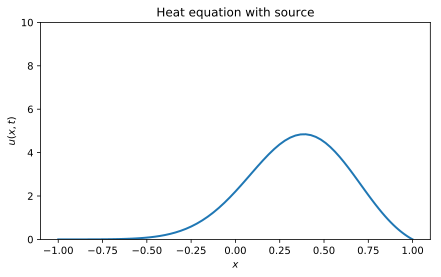

In [48]:
fig,ax = subplots()
curve = ax.plot(x,u0)[0]
ax.set_xlabel("$x$"); ax.set_ylabel("$u(x,t)$");
ax.set_ylim(0,10)
ax.set_title("Heat equation with source");

V = vstack( [sol.sol(tj) for tj in linspace(0,1.5,100)] )
def snapshot(j):
    curve.set_ydata(extend(V[j]))   
FuncAnimation(fig,snapshot,frames=100)

# Example 11.5.5

In [49]:
Smax,T = 8,8
K,sigma,r = 3,0.06,0.08
m = 200  
x,Dx,Dxx = FNC.diffmat2(m,[0,Smax])
h = x[1]-x[0]

Using the boundary conditions and defining the ODE follow next. 

In [50]:
extend = lambda v: hstack([ 0, v, 2/3*(h-0.5*v[m-3]+2*v[m-2]) ])
chop = lambda u: u[1:-1] 
def ODE(t,v):
    u = extend(v)
    ux = Dx@u;  uxx = Dxx@u;
    f = sigma**2/2*x**2*uxx + r*x*ux - r*u
    return chop(f)

Now we define the initial conditions and solve the IVP.

In [51]:
u0 = maximum(0,x-K)
tspan = (0.,T)

sol = solve_ivp(ODE,tspan,chop(u0),dense_output=True)

Extend the solution to the boundaries at each time, then plot/animate.

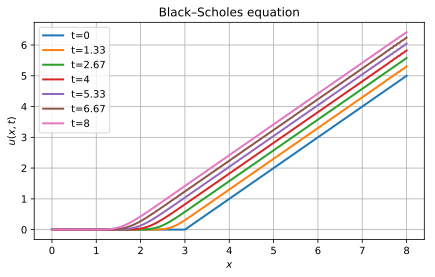

In [52]:
t = linspace(0,T,7) 
U = vstack( [extend(sol.sol(tj)) for tj in t] )
plot(x,U.T)
xlabel("$x$"); ylabel("$u(x,t)$");
legend([f"t={tj:.3g}" for tj in t])
grid(True)
title("Black–Scholes equation");

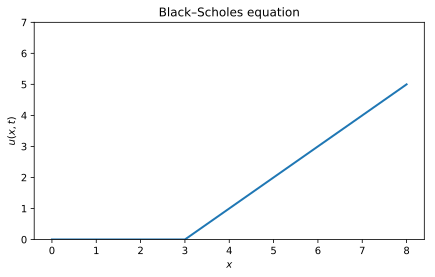

In [53]:
fig,ax = subplots()
curve = ax.plot(x,u0)[0]
ax.set_xlabel("$x$"); ax.set_ylabel("$u(x,t)$");
ax.set_ylim(0,7)
ax.set_title("Black–Scholes equation");

V = vstack( [sol.sol(tj) for tj in linspace(0,T,80)] )
def snapshot(j):
    curve.set_ydata(extend(V[j]))   
FuncAnimation(fig,snapshot,frames=80)